<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ресемплирование</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Скользящие-значения" data-toc-modified-id="Скользящие-значения-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Скользящие значения</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#Недельная-сезонность" data-toc-modified-id="Недельная-сезонность-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Недельная сезонность</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разделение на выборки</a></span></li><li><span><a href="#Добавление-признаков" data-toc-modified-id="Добавление-признаков-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Добавление признаков</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Сравнение моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

Сразу указываем первый столбец индексом и переводим даты в `Dtype`.

In [2]:
try:
    data = pd.read_csv('datasets\\taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0]) 

### Обзор данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропусков нет

Проверяем что данные монотонные

In [4]:
data.index.is_monotonic

True

Проверяю, что шаг между записями всегда 10 минут. Для этого добавляю к индексам 10 минут и сравниваю со следущими.  
Если все сравнения верные, то их сумма будет на один меньше размера датасета.  
Не знаю есть ли для этого автоматическая функция, я не нашла.

In [5]:
(data[1:].index == data[:-1].index + pd.Timedelta(minutes=10)).sum() == data.shape[0] - 1

True

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


В среднем 14 заказов, максимум - 119. Явно аномалия, но значение вполне может быть реальным.

### Ресемплирование

Так как нас интересует количество заказов, то при ресемплировании я буду использовать сумму.

In [7]:
data = data.resample('1H').sum()

In [8]:
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


## Анализ

### Скользящие значения

Рассмотрим скользящее среднее и стандартное отклонение.  
Размер окна я установлю равным 24 - одни сутки. Мне кажется среднее значение за сутки (хоть окна и начинаются каждый час) имеет больше смысла, чем случайное значение.

In [9]:
data_rolling = pd.DataFrame()

In [10]:
data_rolling['1D_rolling_mean'] = data['num_orders'].rolling(24).mean()
data_rolling['1D_rolling_std'] = data['num_orders'].rolling(24).std()

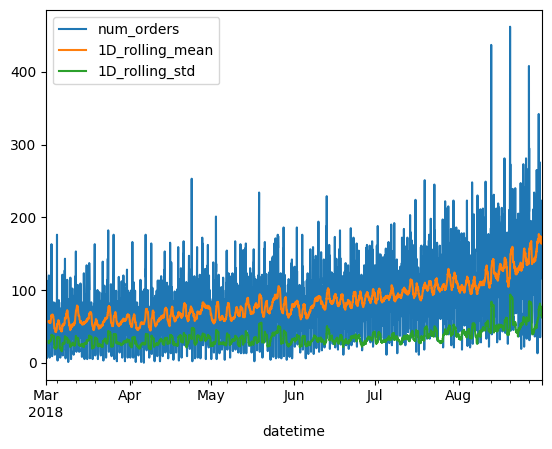

In [11]:
ax = data.plot()
data_rolling.plot(ax=ax);

Видно что среднее растёт, это должно радовать компанию.  
Также растёт и стандартное оклонение. Это значит, что разница между активными часами и тихими растёт, что следует учитывать в работе.

### Тренды и сезонность

In [12]:
decomposed = seasonal_decompose(data['num_orders'])

Посторим графики. Сезонность я рассмотрю за одну неделю, так как у неё график повторяющийся.

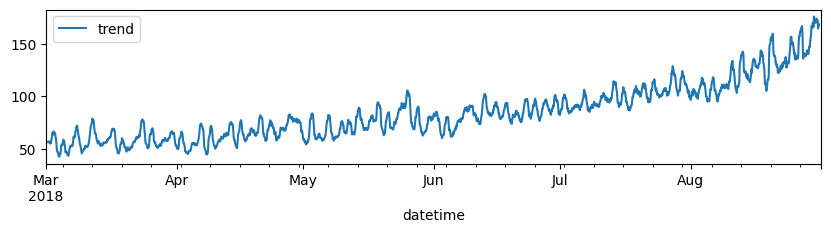

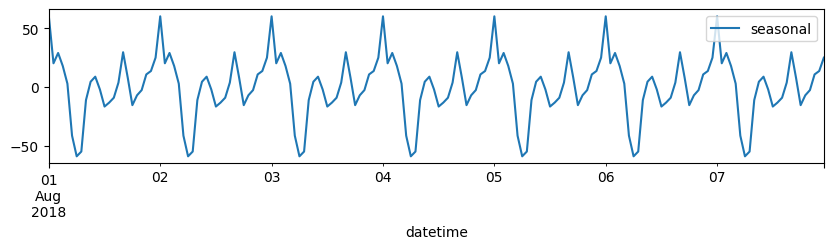

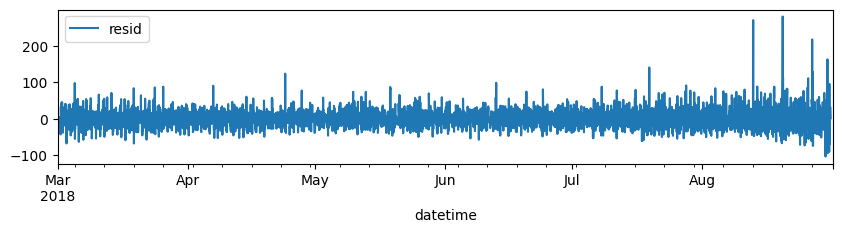

In [13]:
decomposed.trend.plot(figsize=(10,2), legend='trend')
plt.show();
decomposed.seasonal['2018-08-01':'2018-08-07'].plot(figsize=(10,2), legend='seasonal')
plt.show();
decomposed.resid.plot(figsize=(10,2), legend='resid')
plt.show();

Тренд идёт вверх, количество заказов растёт.  
Сезонность имеет период в одни сутки. Самый высокий спрос ночью, когда не ходит общественный транспорт. Самый низкий спрос рано утром. Вероятно в это время совершает посадку меньше самолётов, да и общественный транспорт уже ходит.  
У шума растёт амплитуда, что влияет на стандартное отклонение. 

### Недельная сезонность

Чтобы увидеть недельную сезонность сэмплирование проведём по дням.

In [14]:
data_day = data.resample('1D').sum()

In [15]:
decomposed_day = seasonal_decompose(data_day['num_orders'])

Нас интересует только сезонность. Построим график за несколько недель, начиная с понедельника. Так будет проще читать результат.

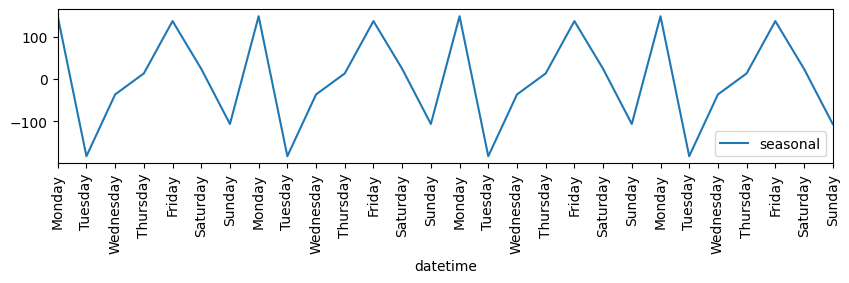

In [16]:
y = pd.DataFrame(decomposed_day.seasonal['2018-07-30':'2018-08-26'])
y['weekday'] = y.index.day_name()
ax = y.plot(y='seasonal',figsize=(10,2), legend='seasonal')
ax.set_xticks(y.index)
ax.set_xticks([], minor=True)
ax.set_xticklabels(y['weekday'], rotation=90)
plt.show();

Период действительно оказался равен одной неделе.  
Самые высокие значения в понедельник и пятницу - начало и конец рабочей недели.  
Самый непопулярный день - вторник.

## Обучение

In [17]:
random_state = 12345

### Разделение на выборки

Разделим данные на выборки. Я разделю данные на три выбоки: train, valid, test.  
Сначала обучая модели на train и проверяя на valid, выберу лучшую модель.  
Затем лучшую модель обучу на объединении train и valid, после чего проверю на test.

In [18]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid =  train_test_split(train, shuffle=False, test_size=0.1)

In [19]:
train.head(2)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85


### Добавление признаков

Для линейной регрессии нам понадобится OHE, обучим его заранее на тренировочных данных.  
В тренировочных данных есть все дни месяца (от 0 до 31), все дни недели (от 0 до 6) и все часы (от 0 до 23). Так что новых значений в тестовых данных возникнуть не может.

In [21]:
data_days = pd.DataFrame()
data_days['hour'] = train.index.hour
data_days['day'] = train.index.day
data_days['dayofweek'] = train.index.dayofweek
enc = OneHotEncoder()
enc.fit(data_days)

OneHotEncoder()

Создадим понятные названия для колонок

In [22]:
hours = ['H_' + x for x in enc.categories_[0].astype(str)]
days = ['D_' + x for x in enc.categories_[1].astype(str)]
dayofweeks = ['WD_' + x for x in enc.categories_[2].astype(str)]
columns = np.concatenate((hours, days, dayofweeks))
columns

array(['H_0', 'H_1', 'H_2', 'H_3', 'H_4', 'H_5', 'H_6', 'H_7', 'H_8',
       'H_9', 'H_10', 'H_11', 'H_12', 'H_13', 'H_14', 'H_15', 'H_16',
       'H_17', 'H_18', 'H_19', 'H_20', 'H_21', 'H_22', 'H_23', 'D_1',
       'D_2', 'D_3', 'D_4', 'D_5', 'D_6', 'D_7', 'D_8', 'D_9', 'D_10',
       'D_11', 'D_12', 'D_13', 'D_14', 'D_15', 'D_16', 'D_17', 'D_18',
       'D_19', 'D_20', 'D_21', 'D_22', 'D_23', 'D_24', 'D_25', 'D_26',
       'D_27', 'D_28', 'D_29', 'D_30', 'D_31', 'WD_0', 'WD_1', 'WD_2',
       'WD_3', 'WD_4', 'WD_5', 'WD_6'], dtype='<U4')

Функция добавления признаков

In [23]:
def make_features(data, max_lag, rolling_mean_size, ohe=False):
    data_features = data.copy()
    
    if ohe:
        days = pd.DataFrame()
        days['hour'] = data.index.hour
        days['day'] = data.index.day
        days['dayofweek'] = data.index.dayofweek
        days = pd.DataFrame(enc.transform(days).toarray(), index=data.index)
        data_features = pd.concat([data_features, days], axis=1)
    else:
        days['hour'] = data.index.hour
        data_features['day'] = data_features.index.day
        data_features['dayofweek'] = data_features.index.dayofweek
        
    for lag in range(1, max_lag + 1):
        data_features['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data_features['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data_features.columns = data_features.columns.astype(str)
    return data_features

In [24]:
data_features_full = data.copy()

# предыдущие 5 часов
for lag in range(2, 6):
    data_features_full['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data_features_full['rolling_mean_{}'.format(lag)] = data['num_orders'].shift().rolling(lag).mean()
    
# предыдущие 7 дней (24 * 7 = 168)
for lag in range(24, 169, 24):
    data_features_full['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data_features_full['rolling_mean_{}'.format(lag)] = data['num_orders'].shift().rolling(lag).mean()

days = pd.DataFrame()
days['hour'] = data.index.hour
days['day'] = data.index.day
days['dayofweek'] = data.index.dayofweek
days = pd.DataFrame(enc.transform(days).toarray(), index=data.index, columns=columns)
data_features_full = pd.concat([data_features_full, days], axis=1)

data_features_full.columns = data_features_full.columns.astype(str)
data_features_full.head()

,num_orders,lag_2,rolling_mean_2,lag_3,rolling_mean_3,lag_4,rolling_mean_4,lag_5,rolling_mean_5,lag_24,...,D_29,D_30,D_31,WD_0,WD_1,WD_2,WD_3,WD_4,WD_5,WD_6
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2018-03-01 02:00:00,71,124.0,104.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2018-03-01 03:00:00,66,85.0,78.0,124.0,93.333333,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2018-03-01 04:00:00,43,71.0,68.5,85.0,74.000000,124.0,86.5,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Полученные данные поделим на выборки.

In [25]:
train_features_full, test_features_full = train_test_split(data_features_full, shuffle=False, test_size=0.1)
train_features_full, valid_features_full =  train_test_split(train_features_full, shuffle=False, test_size=0.1)

# здесь в начале появились пропуски, убираем
train_features_full = train_features_full.dropna().reset_index(drop=True)

y_train = train_features_full['num_orders']
x_train_features_full = train_features_full.drop('num_orders', axis=1)

y_valid = valid_features_full['num_orders']
x_valid_features_full = valid_features_full.drop('num_orders', axis=1)

y_test = test_features_full['num_orders']
x_test_features_full = test_features_full.drop('num_orders', axis=1)

### LinearRegression

In [27]:
linear_model = LinearRegression()
linear_model.fit(x_train_features_full, y_train)
linear_prediction_valid = linear_model.predict(x_valid_features_full)
linear_rmse = mean_squared_error(y_valid, linear_prediction_valid) ** 0.5
print('RMSE = ', linear_rmse)

RMSE =  28.56157936370403


In [28]:
best_linear = pd.DataFrame(data={'model':[linear_model], 'rmse':[linear_rmse]})
best_linear

,model,rmse
0,LinearRegression(),28.561579


### RandomForest

Выделим имена колонок, которые мы будем постепенно добавлять при обучении.  
Выделим следующие категории:  
* только предыдущий час 
* пять предыдущих часов
* часы и предыдущий день
* все колонки


In [29]:
lags = x_train_features_full.filter(regex=("lag_*")).columns
print(lags)
means = x_train_features_full.filter(regex=("rolling_mean_*")).columns
print(means)
cols_len = len(lags)
col_cats = [1, 4, 5, cols_len]

Index(['lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_24', 'lag_48', 'lag_72',
       'lag_96', 'lag_120', 'lag_144', 'lag_168'],
      dtype='object')
Index(['rolling_mean_2', 'rolling_mean_3', 'rolling_mean_4', 'rolling_mean_5',
       'rolling_mean_24', 'rolling_mean_48', 'rolling_mean_72',
       'rolling_mean_96', 'rolling_mean_120', 'rolling_mean_144',
       'rolling_mean_168'],
      dtype='object')


In [30]:
%%time
forest_models = []
for est in range(10, 51, 10):
    for depth in range(5, 16, 5):
        for cat in col_cats:
            x_train_features = train_features_full.drop('num_orders', axis=1)
            x_valid_features = valid_features_full.drop('num_orders', axis=1)
            
            # убираем ненужные столбцы
            x_train_features = x_train_features_full.drop(lags[cat:], axis=1)
            x_train_features = x_train_features.drop(means[cat:], axis=1)
            
            x_valid_features = x_valid_features_full.drop(lags[cat:], axis=1)
            x_valid_features = x_valid_features.drop(means[cat:], axis=1)

            model = RandomForestRegressor(n_estimators=est, 
                                   max_depth=depth, 
                                   random_state=random_state)
            model.fit(x_train_features,y_train)
            
            prediction_valid = model.predict(x_valid_features)
            rmse = mean_squared_error(y_valid, prediction_valid) ** 0.5
            
            forest_models.append([model, cat, est, depth, rmse])

CPU times: total: 30.5 s
Wall time: 30.5 s


In [31]:
forest_models = pd.DataFrame(forest_models)
forest_models.columns = ['model', 'col_cat','n_estimators', 'depth', 'rmse']

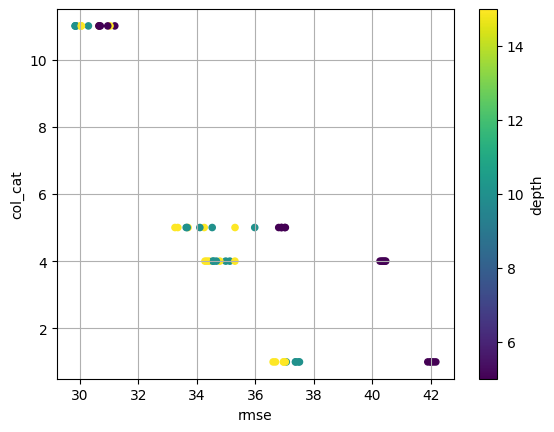

In [32]:
forest_models.plot.scatter(x='rmse',
                      y='col_cat',
                      c='depth',
                      cmap="viridis",
                      grid=True);

In [33]:
best_forest = forest_models[forest_models['rmse'] == forest_models['rmse'].min()]
best_forest

,model,col_cat,n_estimators,depth,rmse
43,"(DecisionTreeRegressor(max_depth=10, max_featu...",11,40,10,29.840541


In [34]:
best_forest_model = best_forest.iloc[0,0]

### CatBoost

In [35]:
%%time
cat_models = []
for iterations in range(500,1501,500):
    for cat in col_cats:
        x_train_features = train_features_full.drop('num_orders', axis=1)
        x_valid_features = valid_features_full.drop('num_orders', axis=1)

        # убираем ненужные столбцы
        x_train_features = x_train_features_full.drop(lags[cat:], axis=1)
        x_train_features = x_train_features.drop(means[cat:], axis=1)

        x_valid_features = x_valid_features_full.drop(lags[cat:], axis=1)
        x_valid_features = x_valid_features.drop(means[cat:], axis=1)

        model = CatBoostRegressor(loss_function='RMSE',
                                  iterations=iterations,
                                  random_seed=random_state)
        model.fit(x_train_features,y_train, verbose=0)

        prediction_train = model.predict(x_train_features)
        prediction_valid = model.predict(x_valid_features)
        rmse = mean_squared_error(y_valid, prediction_valid) ** 0.5

        cat_models.append([model, iterations, cat, rmse])

CPU times: total: 3min 14s
Wall time: 27.9 s


In [36]:
cat_models_df = pd.DataFrame(cat_models)
cat_models_df.columns = ['model','iterations', 'col_cat', 'rmse']

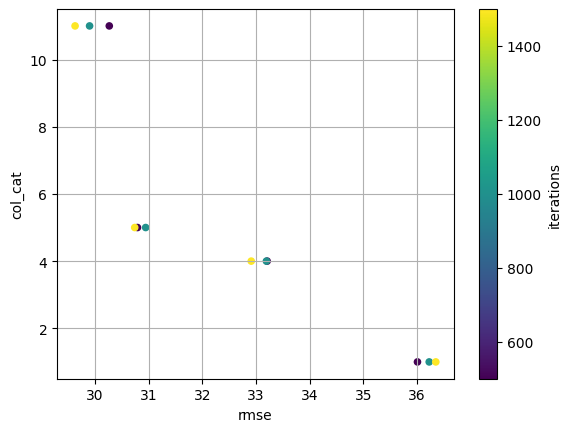

In [37]:
cat_models_df.plot.scatter(x='rmse',
                      y='col_cat',
                      c='iterations',
                      cmap="viridis",
                      grid=True);

In [38]:
best_cat = cat_models_df[cat_models_df['rmse'] == cat_models_df['rmse'].min()]
best_cat

,model,iterations,col_cat,rmse
11,<catboost.core.CatBoostRegressor object at 0x0...,1500,11,29.629173


In [39]:
best_cat_model = best_cat.iloc[0,0]

### Сравнение моделей

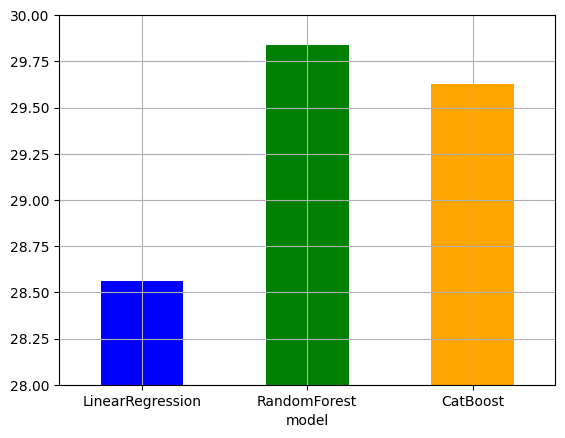

In [40]:
best_models_rmse = pd.DataFrame({
    'model':['LinearRegression', 'RandomForest', 'CatBoost'],
    'RMSE': [best_linear.iloc[0,-1], best_forest.iloc[0,-1], best_cat.iloc[0,-1]]
})
best_models_rmse.plot(kind='bar', 
                      x='model', y='RMSE', 
                      rot=0,color=['Blue','Green','Orange'],
                      ylim=(28,30), grid=True,
                      legend='');

Линейная регрессия показывает лучший результат как по точности, так и по времени работы.

In [41]:
best_model = best_linear.iloc[0]

## Тестирование

Сначала обучим нашу модель на объединении тренировочных и валидационных данных.  
Чтобы не нужно было доставать данные для срезов в тестовые данные из тренировочных, я сначала добавлю дополнительные параметры, а потом разделю выборки.

In [42]:
train_features, test_features = train_test_split(data_features_full, shuffle=False, test_size=0.1)

train_features = train_features.dropna()
y_train = train_features['num_orders']
x_train_features = train_features.drop('num_orders', axis=1)

test_features = test_features.dropna()
y_test = test_features['num_orders']
x_test_features = test_features.drop('num_orders', axis=1)

best_model.model.fit(x_train_features, y_train);

Теперь проверим модель

In [43]:
prediction_test = best_model.model.predict(x_test_features)
rmse_test = mean_squared_error(y_test, prediction_test) ** 0.5
rmse_test.round(2)

34.85

Значение RMSE меньше 48, модель прошла проверку.

In [44]:
pred_previous = y_test.shift() 
pred_previous.iloc[0] = y_train.iloc[-1]
rmse_previous = mean_squared_error(y_test, pred_previous) ** 0.5
rmse_previous

58.856486242815066

Также модель проходит проверку на адкватность.